## Values Ai

###### By Sharareh Noorbaloochi
###### February, 2016

For my Insight project, I chose to develop an app called Values Ai (www.valuesai.me). The app is designed to help political campaigners find the right users on Twitter. I first estimate a Twitter user's 10-dimensional value system (using Schwartz basic human values) and then use the estimated values as my features to predict candidate support. I focused on the top four candidates in the Democratic and Republican party, namely Trump, Cruz, Bernie, and Hillary.

I collected tweets using hashtags #FeelTheBern, #ImWithHer, #CruzCrew, #MakeAmericaGreatAgain from Twitter's rest API. I then identified unique users for each hashtag and collected 200 of their most recent tweets. There are around 1300 unique users per hashtag. I then extracted the value features from tweets text using a custom dictionary of words for the 10 values.

This is only part of the code. I will soon add the twitter scraping, random forest, and model comparison that went along. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
#from ggplot import *
from nltk.corpus import stopwords
import string
from collections import Counter
import csv#import regex
import re
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score #http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import pickle
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from pandas import DataFrame
from sklearn.metrics import roc_auc_score

tknzr = TweetTokenizer()

value_categories =['Self-Direction', 'Stimulation', 'Hedonism', 'Achievement', 'Power',
       'Security', 'Tradition', 'Conformity', 'Benevolence', 'Universalism']

candidates= ["BernieSanders",
"HillaryClinton",
"realDonaldTrump",
"tedcruz"]

svalues = pd.read_csv('SchwartzDictionary.csv',header=0)

d = pd.read_csv("fansSchwartzValues_All_Feb5.csv",header = 0)

#fixing issues with one of the columns
c=[]
for x in d.SupportedCandidate:
    a = x.split()
    c.append(a[1])
d.SupportedCandidate = c

d['party'] = np.where(((d['SupportedCandidate']=='BernieSanders')|(d['SupportedCandidate']=='HillaryClinton')), 
                      'D', 'R')

d= d.drop('Unnamed: 0', 1)

d.to_csv("fansSchwartzValues_All_clean.csv")

dTD = d[(d['SupportedCandidate']=='DonaldTrump')|(d['SupportedCandidate']=='TedCruz')]
dHB = d[(d['SupportedCandidate']=='BernieSanders')|(d['SupportedCandidate']=='HillaryClinton')]


/Users/shararehn/Desktop/Insight/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
dVals = d[['Self-Direction', 'Stimulation', 'Hedonism', 'Achievement', 'Power',
       'Security', 'Tradition', 'Conformity', 'Benevolence', 'Universalism', 
          'SupportedCandidate']]

bygroup_candidate = d.groupby('SupportedCandidate')
summaryDf = bygroup_candidate.describe()
summaryDf.to_csv("SummaryOfFansSchwartzValues_All.csv")

In [3]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Exploring correlations among features

In [5]:
# encode from category to integer coding
le = preprocessing.LabelEncoder()
le.fit(d["SupportedCandidate"])
y=le.transform(d["SupportedCandidate"]) # Bernie=0, Donald =1, Hillary =2, Cruz=3, 
X = d[value_categories]
#X = np.array(X)
labels= le.classes_
print(labels)
print(X.shape)

['BernieSanders' 'DonaldTrump' 'HillaryClinton' 'TedCruz']
(5453, 10)


/Users/shararehn/Desktop/Insight/venv/lib/python2.7/site-packages/seaborn/linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/shararehn/Desktop/Insight/venv/lib/python2.7/site-packages/seaborn/linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


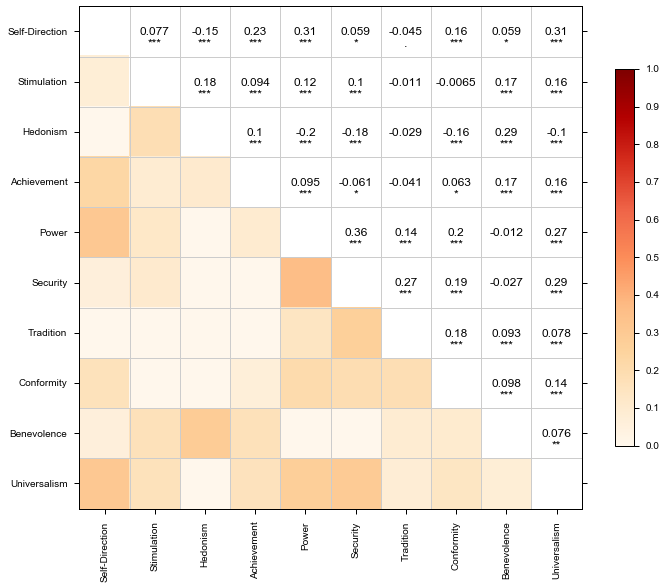

In [6]:
# Exploring correlations among features
import seaborn as sns
import matplotlib.pyplot as plt

kw = {'axes.edgecolor': '0', 'text.color': '0', 'ytick.color': '0', 'xtick.color': '0',
      'ytick.major.size': 5, 'xtick.major.size': 5, 'axes.labelcolor': '0'}
sns.set_style("whitegrid", kw)
f, ax = plt.subplots(figsize=(12, 9))
ax = sns.corrplot(X, diag_names=False, cmap_range=(0,1))


### Compare feature distributions in the four candidate supporters:

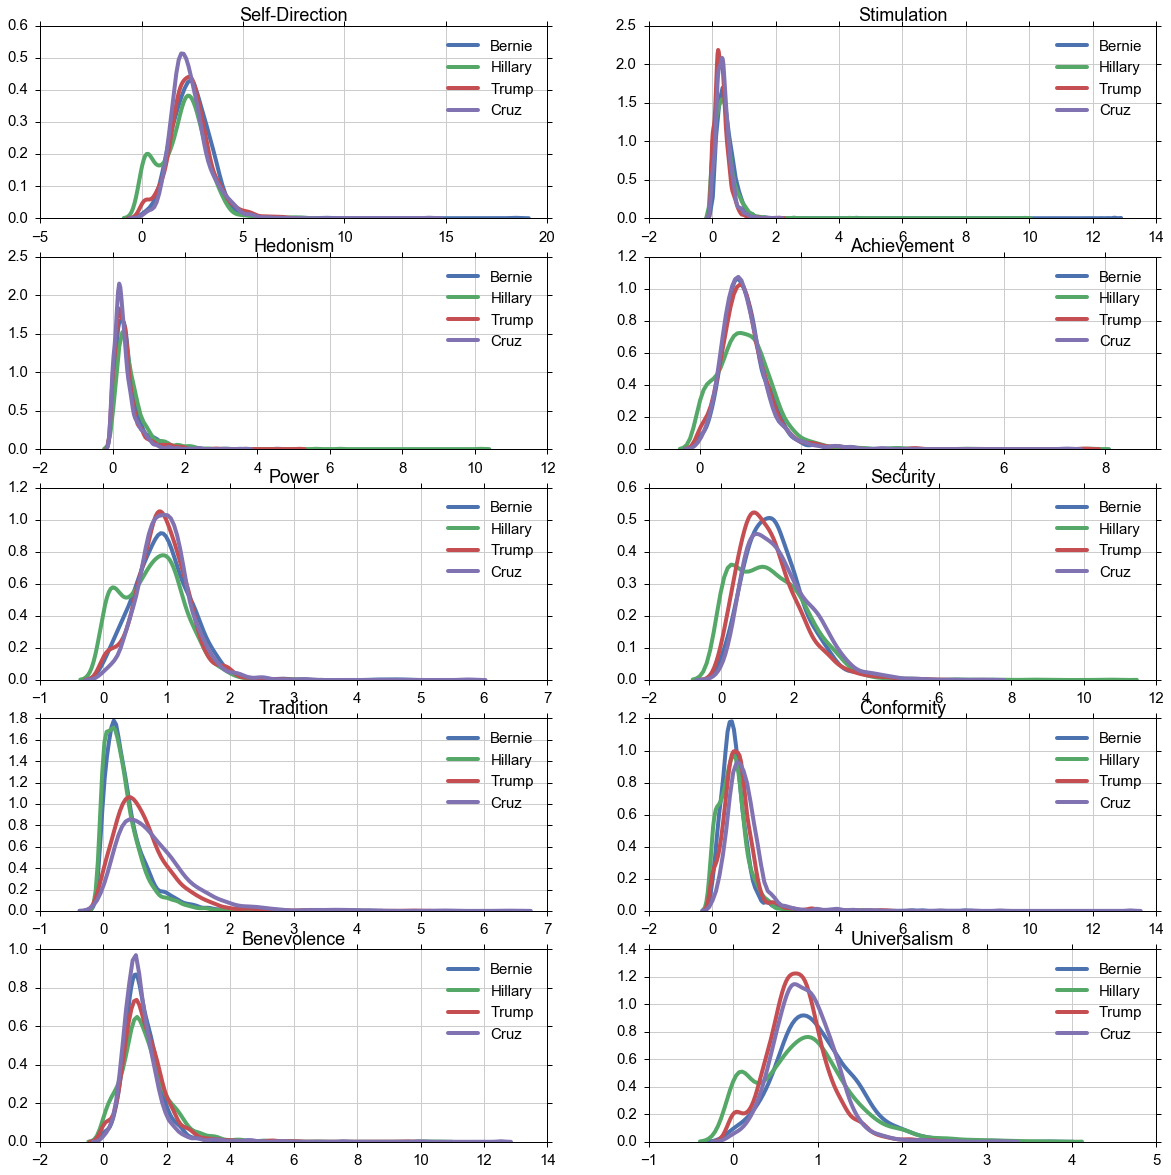

In [8]:

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4})
#sns.set(color_codes="True")
fig, ax = plt.subplots(figsize=(20,20))
for i in range(len(value_categories)):
    c = i+1
    ax = plt.subplot(5,2,c)
    sns.distplot(d[value_categories[i]][d.SupportedCandidate=="BernieSanders"],label="Bernie", kde=True,hist=False,axlabel=False, );
    sns.distplot(d[value_categories[i]][d.SupportedCandidate=="HillaryClinton"],label="Hillary",  kde=True,hist=False,axlabel=False);
    sns.distplot(d[value_categories[i]][d.SupportedCandidate=="DonaldTrump"],label="Trump",  kde=True,hist=False,axlabel=False);
    sns.distplot(d[value_categories[i]][d.SupportedCandidate=="TedCruz"],label="Cruz", kde=True,hist=False,axlabel=False);
    plt.title(value_categories[i])
plt.legend();
plt.show()



### Dividing the data into training and test sets

In [7]:
# Divide the data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

### Model 1: Multinomial Logistic Regression

I first searched for the best hyperparameters, C and regularization method, using GridSearchCV and accuracy as a scoring method. 

In [8]:
###############################################################################
# finding the best parameter for the logistic regression 
from sklearn.metrics import make_scorer, f1_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import ( precision_score, recall_score, f1_score)
from sklearn.metrics import classification_report


gs = GridSearchCV(
    estimator = LogisticRegression(random_state=0, multi_class='multinomial',solver = 'lbfgs'), 
    param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]},
    scoring= 'accuracy',#f1_weighted',
    cv=10)
    
gs = gs.fit(X_train, y_train)
   
print("Best estimator found by grid search:")
print(gs.best_estimator_)
print("Best score:")
print(gs.best_score_)



Best estimator found by grid search:
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
Best score:
0.45919303072


## Performance of the Multinomial Logistic Regression

Training Accuracy: 0.464
Test Accuracy: 0.496
Precison: 0.496
Recall: 0.496
F1: 0.495
[[136  33  69  38]
 [ 37 115  39  75]
 [ 87  21 145  23]
 [ 36  66  26 145]]


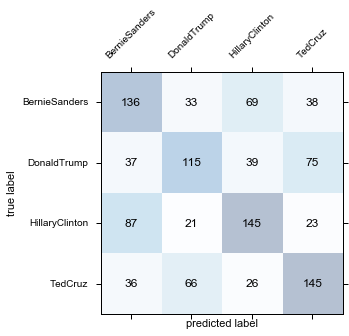

Normalized confusion matrix
[[ 0.49275362  0.11956522  0.25        0.13768116]
 [ 0.13909774  0.43233083  0.14661654  0.28195489]
 [ 0.31521739  0.07608696  0.52536232  0.08333333]
 [ 0.13186813  0.24175824  0.0952381   0.53113553]]


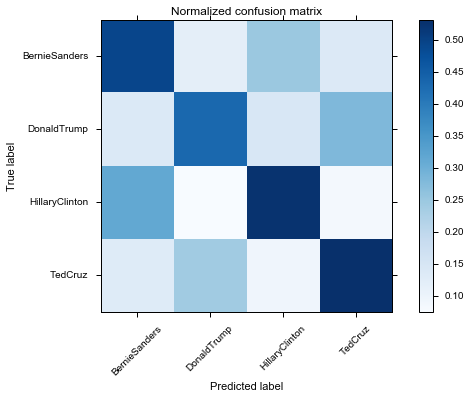

In [11]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
lr = gs.best_estimator_
y_pred = lr.predict(X_test) # lr = LogisticRegression( random_state= 0, solver='lbfgs', multi_class='multinomial',penalty='l2', C=10)

print('Training Accuracy: %.3f' % lr.score(X_train, y_train))
print('Test Accuracy: %.3f' % lr.score(X_test, y_test))
#print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
print('Precison: %.3f' % precision_score(y_test, y_pred,average='weighted'))
print('Recall: %.3f' % recall_score(y_test, y_pred,average='weighted'))
print('F1: %.3f' % f1_score(y_test, y_pred,average='weighted'))

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.grid('off',which='major')
plt.show()


# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)

cm_normalized = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.grid('off',which='major')
plt.show()




### Save the coefficients for the app

In [24]:
import pickle
f = open('lr_classifier_multinomial.pickle', 'wb')
pickle.dump(lr, f)
f.close()

# The coefficients for the presentation
print('Coefficients: \n', lr.coef_)

coef = lr.coef_
print labels
coefData = pd.DataFrame(data= coef)
coefData.to_csv("multReg_coefs_4class.csv")


('Coefficients: \n', array([[ 0.07,  0.63,  0.35, -0.22,  0.11,  0.09, -0.88, -0.42, -0.09,
         0.62],
       [ 0.12, -0.96, -0.3 ,  0.06,  0.21, -0.21,  0.96,  0.1 ,  0.14,
        -0.64],
       [-0.27,  0.42,  0.44,  0.05, -0.43,  0.17, -1.41, -0.2 ,  0.12,
         0.39],
       [ 0.08, -0.09, -0.49,  0.12,  0.1 , -0.05,  1.32,  0.51, -0.18,
        -0.38]]))
['BernieSanders' 'DonaldTrump' 'HillaryClinton' 'TedCruz']


## Predicting political party

['D' 'R']
(5453, 10)
Fitting 10 folds for each of 10 candidates, totalling 100 fits
0.7487391105
{'penalty': 'l1', 'C': 1}
['D' 'R']
Training Accuracy: 0.748
Test Accuracy: 0.757
Precison: 0.772
Recall: 0.713
F1: 0.741
[[446 112]
 [153 380]]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


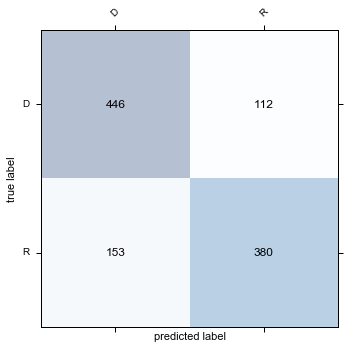

Normalized confusion matrix
[[ 0.79928315  0.20071685]
 [ 0.28705441  0.71294559]]


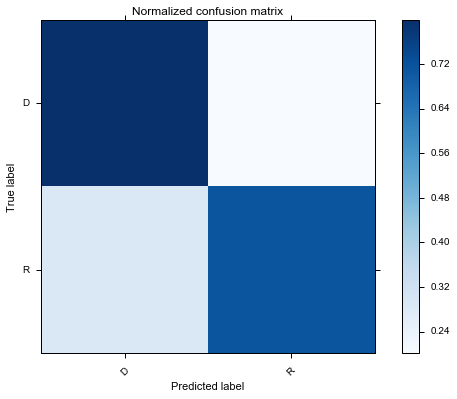

In [14]:
# Predicting political party affiliation Binary Logistic Reg

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix


# encode from category to integer coding
le = preprocessing.LabelEncoder()
le.fit(d["party"])
y=le.transform(d["party"])
X = d[value_categories]
#X = np.array(X)
labels= le.classes_
print labels
print X.shape

# Divide data into training and test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)


# First: find the best parameter combination 
gs = GridSearchCV(
    estimator = LogisticRegression(random_state=0), 
    param_grid = {'penalty': ['l1','l2'],
              'C': [0.01, 0.1, 1, 10, 100]},
    scoring='accuracy',
    cv=10, verbose = 1,
    n_jobs=-1)
    
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

# ------> best parameter the above gives is {penalty='l1', C=1)
lr = gs.best_estimator_
y_pred = lr.predict(X_test) # lr = LogisticRegression( random_state= 0, solver='lbfgs', multi_class='multinomial',penalty='l2', C=10)

coef = lr.coef_
print labels
coefData = pd.DataFrame(data= coef)
coefData.to_csv("coefs_party.csv")

print('Training Accuracy: %.3f' % lr.score(X_train, y_train))
print('Test Accuracy: %.3f' % lr.score(X_test, y_test))
#print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
print('Precison: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.grid('off',which='major')
plt.show()


# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = confmat.astype('float') / confmat.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.grid('off',which='major')
plt.show()

## TF + multinomial logistic method (instead of Values)


In [19]:
# encode from category to integer coding
le = preprocessing.LabelEncoder()
le.fit(d["SupportedCandidate"])
y=le.transform(d["SupportedCandidate"]) # Bernie=0, Donald =1, Hillary =2, Cruz=3, 
X_text = d.tweets_text
#X = np.array(X)
# labels= le.classes_
# print labels
#print X_text.shape

# Divide the data into training and test data sets
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.20, random_state=10)



In [95]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline

def tokener2(s): # tokenize, remove stop words, puncts, mentions, RT and links 
    tokens = tknzr.tokenize(s)
    tokens = tokens
    punctuation = list(string.punctuation)
    stop = stopwords.words('english') + punctuation + ['rt', 'via','RT','...',':/','r',
                                                       'bernie','cruz','hillary','trump',
                                                      'clinton','jeb','marco','sanders','donald','ted',
                                                       'sarah'] 
    #stop = punctuation + ['rt', 'via','RT','...']
    tokens_cleaned = [term.lower() for term in tokens if term.lower() 
                      not in stop and not term.startswith(('@','ht','rhttps','#'))]
    return tokens_cleaned


countV = CountVectorizer(tokenizer= tokener2, stop_words='english', strip_accents='ascii',max_features = 5000, ngram_range=(1,1))
# countV.get_feature_names()
#print(X_train.toarray())

X_trainW = countV.fit_transform(X_text_train) #term frequency
X_testW = countV.transform(X_text_test)



In [240]:

gs = GridSearchCV(
    estimator = LogisticRegression(random_state=0, multi_class='multinomial',solver = 'lbfgs'), 
    param_grid = {'C': [0.1, 1, 10, 100]},
    scoring= 'accuracy',#f1_weighted',
    cv=5)
    
gs = gs.fit(X_trainW, y_train)
   
print("Best estimator found by grid search:")
print(gs.best_estimator_)
print("Best score:")
print(gs.best_score_)




Best estimator found by grid search:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
Best score:
0.702888583219


Training Accuracy: 1.000
Test Accuracy: 0.724
Precison: 0.727
Recall: 0.724
F1: 0.725
[[195  31  37  13]
 [ 32 187  15  32]
 [ 35  24 201  16]
 [ 15  45   6 207]]


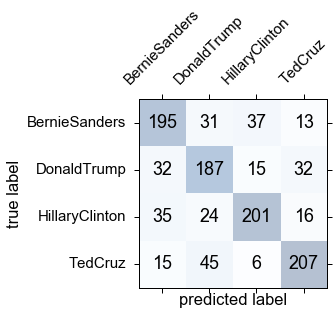

Normalized confusion matrix
[[ 0.71  0.11  0.13  0.05]
 [ 0.12  0.7   0.06  0.12]
 [ 0.13  0.09  0.73  0.06]
 [ 0.05  0.16  0.02  0.76]]


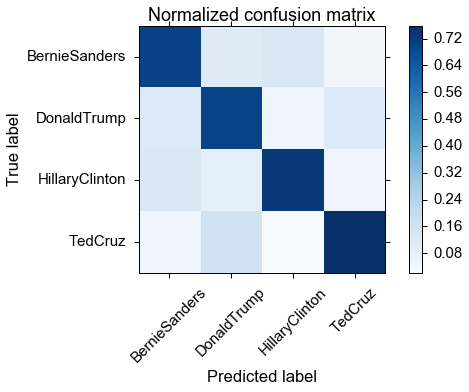

In [243]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
lr2 = gs.best_estimator_
y_pred2 = lr2.predict(X_testW) # lr = LogisticRegression( random_state= 0, solver='lbfgs', multi_class='multinomial',penalty='l2', C=10)
y_pred2_prob = lr2.predict_proba(X_testW)

y_pred2_prob
print('Training Accuracy: %.3f' % lr2.score(X_trainW, y_train))
print('Test Accuracy: %.3f' % lr2.score(X_testW, y_test))
#print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred))
print('Precison: %.3f' % precision_score(y_test, y_pred2,average='weighted'))
print('Recall: %.3f' % recall_score(y_test, y_pred2,average='weighted'))
print('F1: %.3f' % f1_score(y_test, y_pred2,average='weighted'))

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred2)
print(confmat)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.grid('off',which='major')
plt.show()

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = confmat.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.grid('off',which='major')
plt.show()